In [1]:
import warnings
import pandas as pd
import numpy as np
import pandas_profiling
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *
%matplotlib inline

d:\Downloads\New folder\envs\credit_risk\lib\site-packages\numba\core\decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
d:\Downloads\New folder\envs\credit_risk\lib\site-packages\visions\backends\shared\nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:


In [2]:
application_train = pd.read_csv(r"d:\NEU\Credit-Risk-Analysis\data\dseb-63-data-preparation-final-project\dseb63_final_project_DP_dataset\dseb63_final_project_DP_dataset\dseb63_application_train.csv")
application_test = pd.read_csv(r"d:\NEU\Credit-Risk-Analysis\data\dseb-63-data-preparation-final-project\dseb63_final_project_DP_dataset\dseb63_final_project_DP_dataset\dseb63_application_test.csv")
ins_pay = pd.read_csv(r"d:\NEU\Credit-Risk-Analysis\data\dseb-63-data-preparation-final-project\dseb63_final_project_DP_dataset\dseb63_final_project_DP_dataset\dseb63_installments_payments.csv")
#ins_pay_profile = ins_pay.profile_report(title="Install Paayment dataset report")
#ins_pay_profile 

In [3]:
print(f'The shape of installments_payments.csv is: {ins_pay.shape}')
print(f'Number of unique SK_ID_PREV in installments_payments.csv are: {len(ins_pay.SK_ID_PREV.unique())}')
print(f'Number of unique SK_ID_CURR in installments_payments.csv are: {len(ins_pay.SK_ID_CURR.unique())}')
print(f'Number of overlapping SK_ID_CURR in application_train.csv and installments_payments.csv are: {len(set(application_train.SK_ID_CURR.unique()).intersection(set(ins_pay.SK_ID_CURR.unique())))}')
print(f'Number of overlapping SK_ID_CURR in application_test.csv and installments_payments.csv are: {len(set(application_test.SK_ID_CURR.unique()).intersection(set(ins_pay.SK_ID_CURR.unique())))}')
print(f'Number of duplicate values in installments_payments: {ins_pay.shape[0] - ins_pay.duplicated().shape[0]}')

The shape of installments_payments.csv is: (7744758, 8)
Number of unique SK_ID_PREV in installments_payments.csv are: 549020
Number of unique SK_ID_CURR in installments_payments.csv are: 180734
Number of overlapping SK_ID_CURR in application_train.csv and installments_payments.csv are: 144408
Number of overlapping SK_ID_CURR in application_test.csv and installments_payments.csv are: 36325
Number of duplicate values in installments_payments: 0


In [4]:
def check_missed_values(df):
    df_null_percentage = df.isnull().sum() / df.shape[0] * 100
    df_null_percentage = df_null_percentage.drop(df_null_percentage[df_null_percentage == 0].index).sort_values(ascending= False).reset_index()
    df_null_percentage.columns = ["Feature", "Percentage"]
    return df_null_percentage

check_missed_values(ins_pay)

,Feature,Percentage
0,DAYS_ENTRY_PAYMENT,0.021163
1,AMT_PAYMENT,0.021163
2,AMT_INSTALMENT,0.000013
3,SK_ID_CURR,0.000013


In [5]:
ins_pay.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7744758 entries, 0 to 7744757
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int64  
 1   NUM_INSTALMENT_VERSION  float64
 2   NUM_INSTALMENT_NUMBER   int64  
 3   DAYS_INSTALMENT         float64
 4   DAYS_ENTRY_PAYMENT      float64
 5   AMT_INSTALMENT          float64
 6   AMT_PAYMENT             float64
 7   SK_ID_CURR              float64
dtypes: float64(6), int64(2)
memory usage: 472.7 MB


#### OBSERVATION from instalment_payment.csv

- There are ~13605401 observations with 8 features list below:
    - SK_ID_PREV: ID of previous credit in Home Credit related to loan in our sample
    - SK_ID_CURR: ID of loan in our sample
    - NUM_INSTALMENT_VERSION: Version of installment calendar (0 is for credit card) of previous credit. Change of installment version from month to month signifies that some parameter of payment calendar has changed

    - NUM_INSTALMENT_NUMBER : On which installment we observe payment (lan tra gop so bao nhieu)

    - DAYS_INSTALMENT: When the installment of previous credit was supposed to be paid (relative to application date of current loan),time only relative to the application (ngay tra gop)
    - DAYS_ENTRY_PAYMENT: When was the installments of previous credit paid actually (ngay ma khach hang that su tra)
    - AMT_INSTALMENT: What was the prescribed installment amount of previous credit on this installment (luong tien tra gop dang ra khach hang phai tra)
    - AMT_PAYMENT: What the client actually paid on previous credit on this installment ( luong tien tra gop ma khach hang that su tra)

## EDA

### Merge the TARGETS from application_train to ins_pay

In [6]:
ins_pay_merge = pd.merge(application_train[["SK_ID_CURR", "TARGET"]], ins_pay, how='left', on=['SK_ID_CURR'])
#ins_pay_merge_profile = ins_pay_merge.profile_report(title="installment_payment merged dataset report")
#ins_pay_merge_profile

#### Univariate Analysis : Num_Instalment_Number

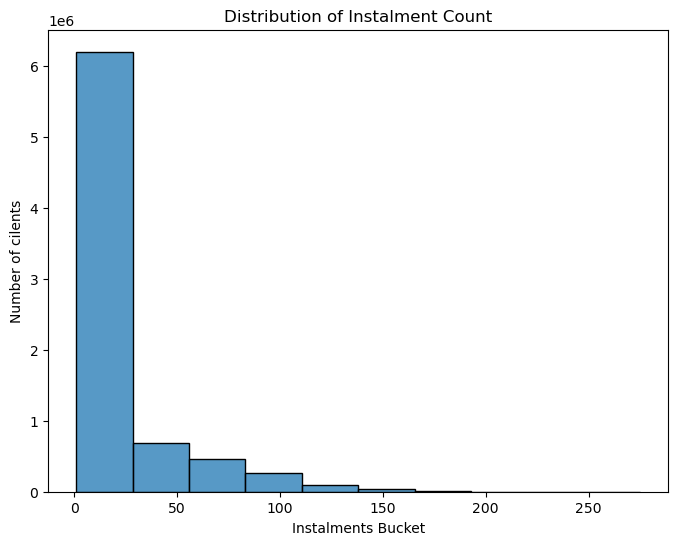

In [7]:
# Create a bar plot
plt.figure(figsize=(8, 6))
sns.histplot(ins_pay['NUM_INSTALMENT_NUMBER'].values, bins=10, palette = 'Set1')

# Set plot labels and title
plt.ylabel("Number of cilents")
plt.xlabel('Instalments Bucket')
plt.title("Distribution of Instalment Count")


# Show the plot
plt.show()

- Observations :
Most of the clients complete their instalment payment before 25 months.

#### Univariate Analysis : Amt_Payment

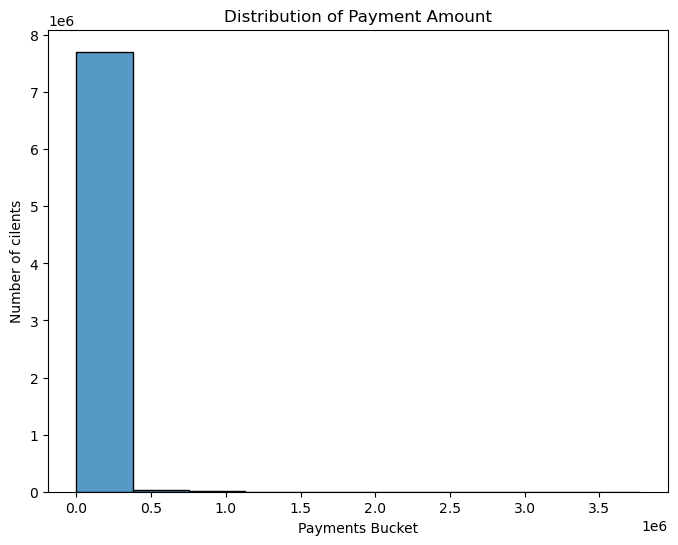

In [8]:
# Create a bar plot
plt.figure(figsize=(8, 6))
sns.histplot(ins_pay['AMT_PAYMENT'].values, bins=10, palette = 'Set1')

# Set plot labels and title
plt.ylabel("Number of cilents")
plt.xlabel('Payments Bucket')
plt.title("Distribution of Payment Amount")


# Show the plot
plt.show()

-  Observations :
Most of the clients paid less than 5 lakh on previous credit on the same installment.

### Bivariate Analysis

### Bivariate Analysis: DAYS_INSTALMENT vs DEFAULTER (TARGET=1)

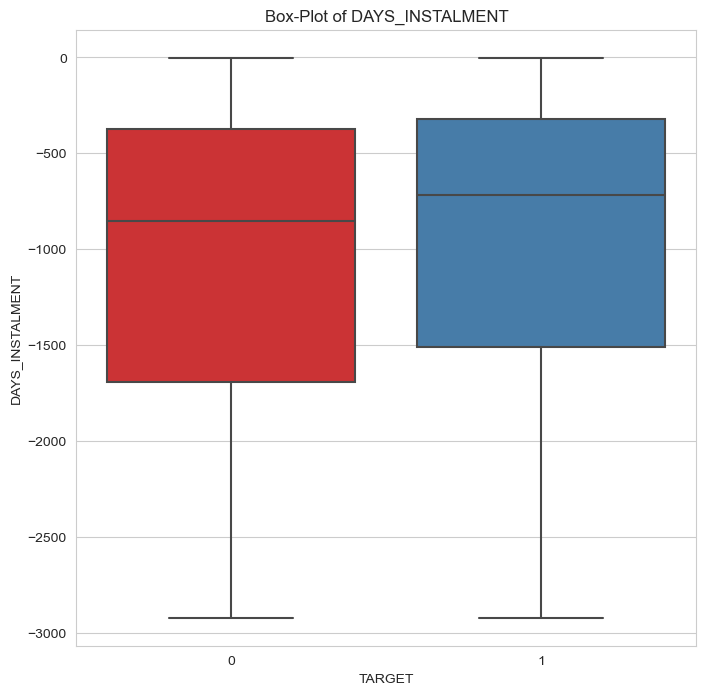

In [9]:
plot_continuous_variables(ins_pay_merge, 'DAYS_INSTALMENT', plots = ['box'], figsize = (8,8))

### Bivariate Analysis: DAYS_ENTRY_PAYMENT vs DEFAULTER (TARGET=1)

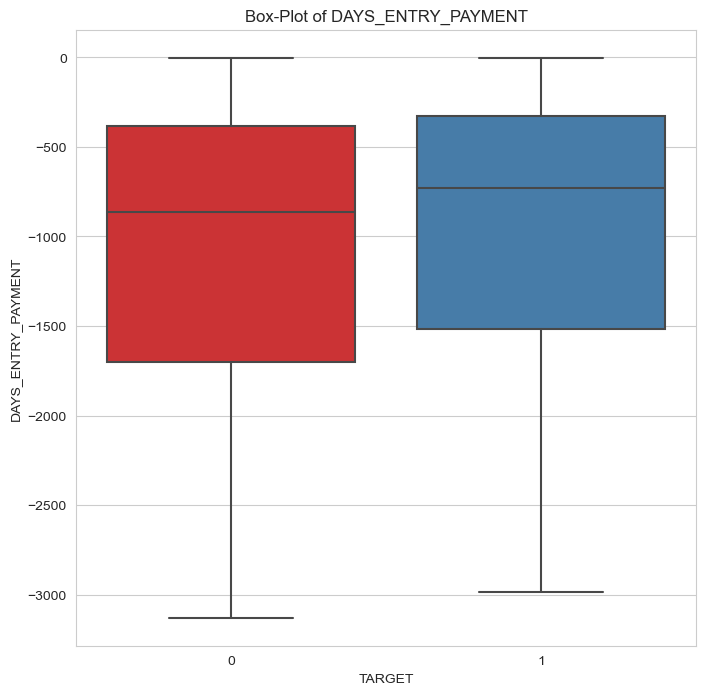

In [10]:
plot_continuous_variables(ins_pay_merge, 'DAYS_ENTRY_PAYMENT', plots = ['box'], figsize = (8,8))
